# Подготовка библиотек

In [70]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

"git" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

# Проверить устройства для кераса

In [72]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14433219257146989567
xla_global_id: -1
]


# Функции для визуализации

In [73]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [74]:
DATASET_PATH = 'clothing-co-parsing/photos/'
MASKS_PATH = 'clothing-co-parsing/annotations/pixel-level/'

In [75]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [76]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(DATASET_PATH + image_filename))
    images.append(preprocess_image(image))

    mask_file = io.loadmat(MASKS_PATH + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth']) 
    masks.append(preprocess_mask(mask))

In [77]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [78]:
train

<ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [79]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [80]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [81]:
len(train)

6424

In [82]:
train_X

<TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [83]:
train

<ConcatenateDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [84]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

In [85]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

In [87]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [115]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [116]:
base_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_17')>

In [117]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [118]:
def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [119]:
test

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [120]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [121]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Epoch 1/10
1/1 [==============================] - 1s 682ms/step loss: 0.1723 - accuracy: 0.92


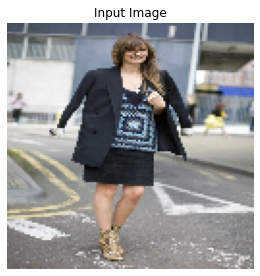

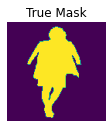

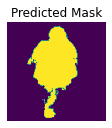


Sample Prediction after epoch 1

201/201 [==============================] - 113s 544ms/step - loss: 0.1723 - accuracy: 0.9273 - val_loss: 0.0998 - val_accuracy: 0.9610
Epoch 2/10
1/1 [==============================] - 0s 23ms/step- loss: 0.0782 - accuracy: 0.96


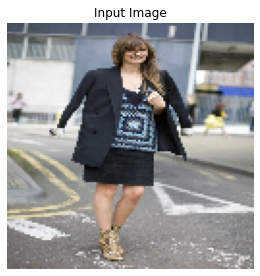

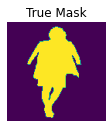

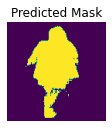


Sample Prediction after epoch 2

201/201 [==============================] - 106s 529ms/step - loss: 0.0782 - accuracy: 0.9693 - val_loss: 0.0841 - val_accuracy: 0.9677
Epoch 3/10
1/1 [==============================] - 0s 22ms/step- loss: 0.0612 - accuracy: 0.97


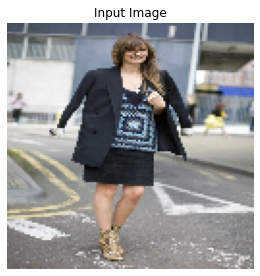

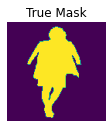

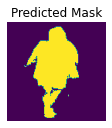


Sample Prediction after epoch 3

201/201 [==============================] - 106s 529ms/step - loss: 0.0612 - accuracy: 0.9762 - val_loss: 0.0792 - val_accuracy: 0.9704
Epoch 4/10
1/1 [==============================] - 0s 22ms/step- loss: 0.0516 - accuracy: 0.97


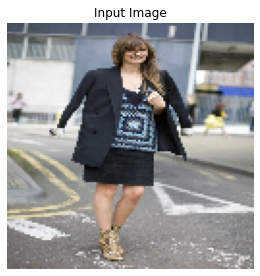

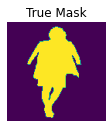

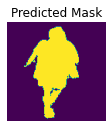


Sample Prediction after epoch 4

201/201 [==============================] - 107s 529ms/step - loss: 0.0516 - accuracy: 0.9799 - val_loss: 0.0789 - val_accuracy: 0.9714
Epoch 5/10
1/1 [==============================] - 0s 23ms/step- loss: 0.0437 - accuracy: 0.98


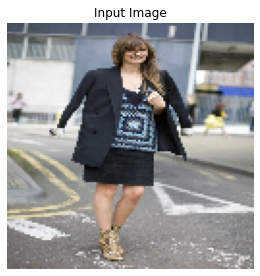

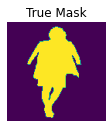

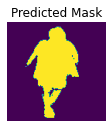


Sample Prediction after epoch 5

201/201 [==============================] - 107s 529ms/step - loss: 0.0437 - accuracy: 0.9829 - val_loss: 0.0839 - val_accuracy: 0.9713
Epoch 6/10
1/1 [==============================] - 0s 22ms/step- loss: 0.0373 - accuracy: 0.98


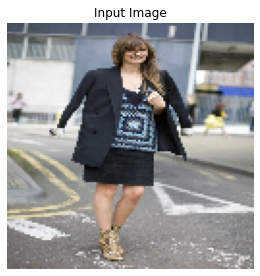

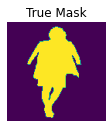

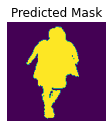


Sample Prediction after epoch 6

201/201 [==============================] - 106s 529ms/step - loss: 0.0373 - accuracy: 0.9854 - val_loss: 0.0867 - val_accuracy: 0.9717
Epoch 7/10
1/1 [==============================] - 0s 22ms/step- loss: 0.0329 - accuracy: 0.98


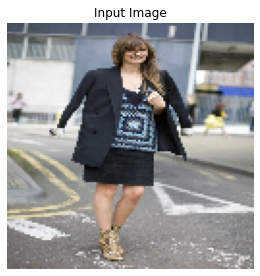

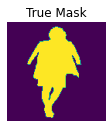

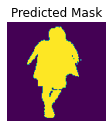


Sample Prediction after epoch 7

201/201 [==============================] - 107s 531ms/step - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.0899 - val_accuracy: 0.9724
Epoch 8/10
1/1 [==============================] - 0s 23ms/step- loss: 0.0289 - accuracy: 0.98


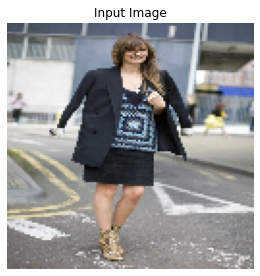

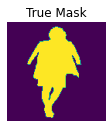

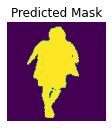


Sample Prediction after epoch 8

201/201 [==============================] - 107s 531ms/step - loss: 0.0289 - accuracy: 0.9886 - val_loss: 0.0952 - val_accuracy: 0.9721
Epoch 9/10
1/1 [==============================] - 0s 25ms/step- loss: 0.0260 - accuracy: 0.98


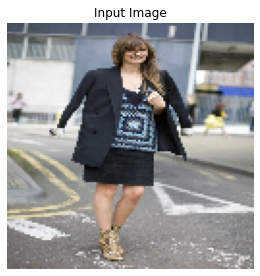

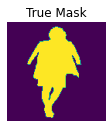

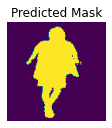


Sample Prediction after epoch 9

201/201 [==============================] - 107s 532ms/step - loss: 0.0260 - accuracy: 0.9897 - val_loss: 0.0963 - val_accuracy: 0.9722
Epoch 10/10
1/1 [==============================] - 0s 25ms/step- loss: 0.0239 - accuracy: 0.99


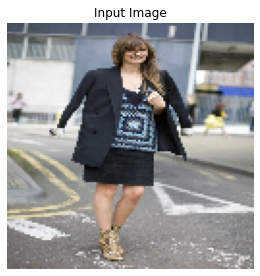

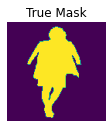

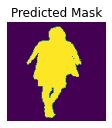


Sample Prediction after epoch 10

201/201 [==============================] - 107s 533ms/step - loss: 0.0239 - accuracy: 0.9905 - val_loss: 0.1042 - val_accuracy: 0.9721


In [122]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

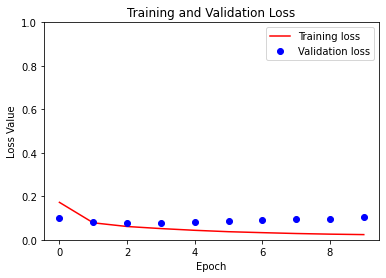

In [123]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 308ms/step


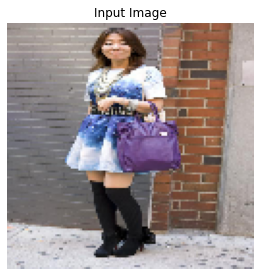

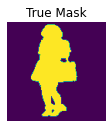

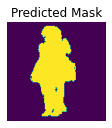

1/1 [==============================] - 0s 316ms/step


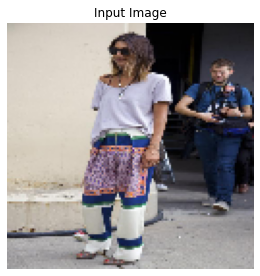

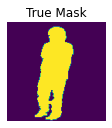

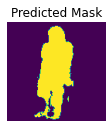

1/1 [==============================] - 0s 303ms/step


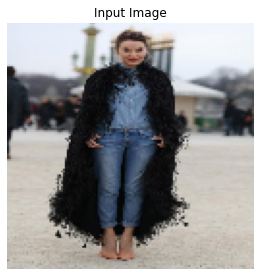

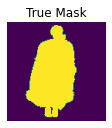

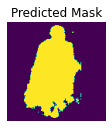

In [125]:
show_predictions(model, test, 3)